<a href="https://colab.research.google.com/github/nikhelll/Finance-Tidbits/blob/main/LSTM_Moving_Average_Crossover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

[*********************100%***********************]  1 of 1 completed


Epoch 1/50
40/40 [==============================] - 9s 45ms/step - loss: 0.6924 - accuracy: 0.5228 - val_loss: 0.6943 - val_accuracy: 0.5204
Epoch 2/50
40/40 [==============================] - 1s 22ms/step - loss: 0.6921 - accuracy: 0.5291 - val_loss: 0.6974 - val_accuracy: 0.5204
Epoch 3/50
40/40 [==============================] - 1s 17ms/step - loss: 0.6921 - accuracy: 0.5291 - val_loss: 0.6934 - val_accuracy: 0.5204
Epoch 4/50
40/40 [==============================] - 1s 17ms/step - loss: 0.6919 - accuracy: 0.5291 - val_loss: 0.6955 - val_accuracy: 0.5204
Epoch 5/50
40/40 [==============================] - 1s 17ms/step - loss: 0.6915 - accuracy: 0.5291 - val_loss: 0.6954 - val_accuracy: 0.5204
Epoch 6/50
40/40 [==============================] - 1s 17ms/step - loss: 0.6914 - accuracy: 0.5291 - val_loss: 0.6975 - val_accuracy: 0.5204
Epoch 7/50
40/40 [==============================] - 1s 17ms/step - loss: 0.6916 - accuracy: 0.5291 - val_loss: 0.6962 - val_accuracy: 0.5204
Epoch 8/50
40

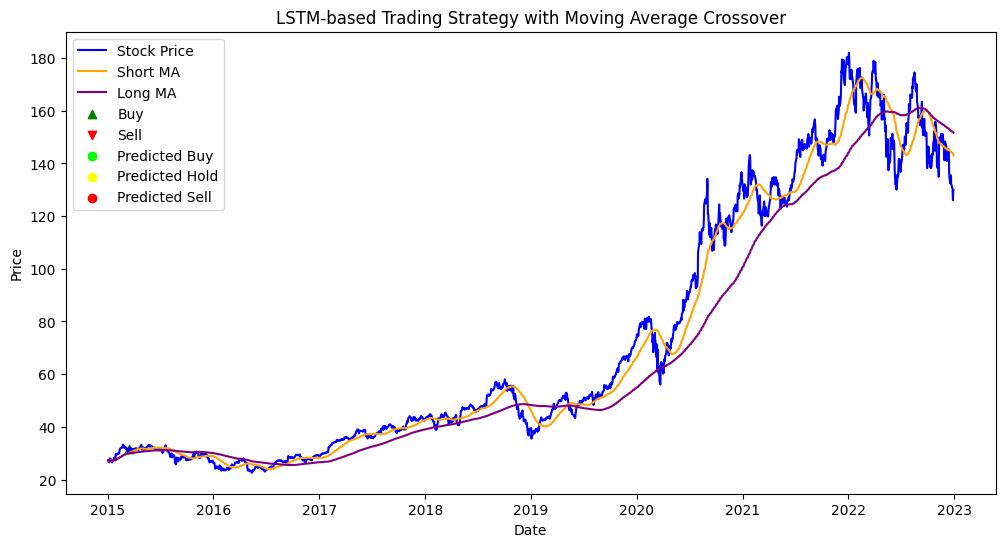

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    return model

def create_lstm_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(1 if data[i+window_size] > data[i+window_size-1] else 0)
    return np.array(X), np.array(y)

def moving_average_crossover_strategy(data, short_window=50, long_window=200):
    signals = pd.DataFrame(index=data.index)
    signals['Price'] = data['Close']

    # Create short and long simple moving averages
    signals['Short_MA'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['Long_MA'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Create signals
    signals['Signal'] = 0
    signals.loc[signals['Short_MA'] > signals['Long_MA'], 'Signal'] = 1
    signals.loc[signals['Short_MA'] < signals['Long_MA'], 'Signal'] = -1

    # Calculate positions (1: buy, -1: sell, 0: hold)
    signals['Position'] = signals['Signal'].diff()

    return signals

def backtest_strategy(signals, initial_balance=10000):
    balance = initial_balance
    holdings = 0
    for index, signal in signals.iterrows():
        if signal['Position'] == 1:  # Buy signal
            holdings = balance / signal['Price']
            balance = 0
        elif signal['Position'] == -1:  # Sell signal
            balance = holdings * signal['Price']
            holdings = 0

    # If the strategy still has holdings by the end of the backtest period, sell them
    balance += holdings * signals.iloc[-1]['Price']

    return balance

# Define the stock symbol and time period for data retrieval
stock_symbol = 'AAPL'
start_date = '2015-01-01'
end_date = '2023-01-01'

# Fetch historical stock price data using yfinance
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create LSTM dataset with a window size of 20
window_size = 20
X_train, y_train = create_lstm_dataset(train_data, window_size)
X_test, y_test = create_lstm_dataset(test_data, window_size)

# Reshape the input data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create and train the LSTM model
model = create_lstm_model(input_shape=(window_size, 1))
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred).flatten()

# Convert predictions back to original scale
y_pred_original = scaler.inverse_transform(y_pred_binary.reshape(-1, 1)).flatten()

# Add predicted price movement as a new column to the data
data['Predicted_Movement'] = np.nan
data.iloc[train_size+window_size:, data.columns.get_loc('Predicted_Movement')] = y_pred_original

# Implement the strategy based on predicted price movements
signals = moving_average_crossover_strategy(data)

# Perform backtesting and calculate the final balance
final_balance = backtest_strategy(signals)
print("Final Balance: ${:.2f}".format(final_balance))

# Plot the stock price, moving averages, and predicted price movements
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Stock Price', color='blue')
plt.plot(signals.index, signals['Short_MA'], label='Short MA', color='orange')
plt.plot(signals.index, signals['Long_MA'], label='Long MA', color='purple')
plt.scatter(signals[signals['Position'] == 1].index, signals[signals['Position'] == 1]['Price'], label='Buy', marker='^', color='green')
plt.scatter(signals[signals['Position'] == -1].index, signals[signals['Position'] == -1]['Price'], label='Sell', marker='v', color='red')
plt.scatter(data[data['Predicted_Movement'] == 1].index, data[data['Predicted_Movement'] == 1]['Close'], label='Predicted Buy', marker='o', color='lime')
plt.scatter(data[data['Predicted_Movement'] == 0].index, data[data['Predicted_Movement'] == 0]['Close'], label='Predicted Hold', marker='o', color='yellow')
plt.scatter(data[data['Predicted_Movement'] == -1].index, data[data['Predicted_Movement'] == -1]['Close'], label='Predicted Sell', marker='o', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM-based Trading Strategy with Moving Average Crossover')
plt.legend()
plt.show()